In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import pickle
import wntr
import wntr.metrics.economic as economics
import numpy as np
import pandas as pd
import pdb
import os

import sys
sys.path.append('../Code/')
from testWN import testWN as twm
from surrogate_model_training_data import get_data

from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression

In [2]:
%load_ext autoreload
%autoreload 2
%matplotlib notebook

In [3]:
from surrogate_model_training_data import get_data

# Get network informations

In [4]:
inp_file = '../Code/c-town_true_network_simplified_controls.inp'
ctown = twm(inp_file)
nw_node_df = pd.DataFrame(ctown.wn.nodes.todict())
nw_link_df = pd.DataFrame(ctown.wn.links.todict())

node_names = ctown.getNodeName()
link_names = ctown.getLinkName()

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/wntr/epanet/io.py:2088: UserWarning:

Not all curves were used in "../Code/c-town_true_network_simplified_controls.inp"; added with type None, units conversion left to user



# Data Pre-Processing

Get clusters:

In [5]:
cluster_label_path = '../clustering/'
cluster_labels = pd.read_json(cluster_label_path+'cluster_labels_with_mpc.json')
pressure_factor = pd.read_json(cluster_label_path+'pressure_factor_with_mpc.json')
n_clusters = 30

# Create Training Data:

## with random control input:

In [6]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_1hourSampling/'
file_list = os.listdir(data_path)
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]
n_arx = 0
nn_input_rc, nn_output_rc = get_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False, shift_x=True)
nn_input_rc.shape

(100660, 46)

Apply filters:

In [7]:
def filter_io(nn_input, nn_output):
    # All filters are formulated, such that they select data to be removed.
    
    f_1 = (nn_output[('aux_outputs','pump_energy')]<=-10).any(axis=1)
    f_2 = (nn_output[('aux_outputs','jun_cl_press_mean')]<=0).any(axis=1)

    # Maximum junction pressure should not exceed .. :
    jun_cl_press_fac_max = pressure_factor.groupby(cluster_labels.loc['pressure_cluster'], axis=1).max()
    f_3 = ((nn_output[('aux_outputs','jun_cl_press_mean')]*jun_cl_press_fac_max.to_numpy())>=400).any(axis=1)

    # Tank level should not become smaller than 0.2 at next timestep:
    f_4 = ((nn_input[('sys_states','tank_press')]+nn_output[('sys_states','tank_press')])<0.5).any(axis=1)
    
    # Tank level should not be at the maximum
    #max_tank_level = np.array([6.75, 6.5, 5, 5.5, 4.5, 5.9, 4.7]).reshape(1,-1)
    #f_5 = ((nn_input[('sys_states','tank_press')]+nn_output[('sys_states','tank_press')])>max_tank_level-0.01).any(axis=1)
    
    min_pump_setting = np.array([0.36, 0.66, 0.66, 0.56, 0.56]).reshape(1,-1)
    f_5 = (nn_input[('sys_inputs','head_pump_speed')]<min_pump_setting).any(axis=1)
    
    f = ~f_1&~f_2&~f_3&~f_4&~f_5
    return f

In [8]:
f = filter_io(nn_input_rc, nn_output_rc)
nn_input_rc_filtered = nn_input_rc.loc[f]
nn_output_rc_filtered = nn_output_rc.loc[f]
nn_input_rc_filtered.shape

/home/ffiedler/miniconda3/envs/py37_WNTR/lib/python3.7/site-packages/IPython/core/interactiveshell.py:2881: PerformanceWarning:

indexing past lexsort depth may impact performance.



(4462, 46)

## without random control input:

In [9]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_noControls/'
file_list = os.listdir(data_path)
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]

n_arx = 0
nn_input_nc, nn_output_nc = get_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False, shift_x=True)
nn_input_nc.shape

(100660, 46)

In [10]:
# Manually setting the pump setting to the lowest value that results in a shutoff.
min_pump_setting = np.array([0.36, 0.66, 0.66, 0.56, 0.56])
for i,pump_i in enumerate(link_names[0]):
    f1 = (nn_input_nc[('sys_inputs','head_pump_speed',pump_i)]<min_pump_setting[i])
    nn_input_nc[('sys_inputs','head_pump_speed',pump_i)].loc[f1] = min_pump_setting[i]  

In [11]:
f = filter_io(nn_input_nc, nn_output_nc)
nn_input_nc_filtered = nn_input_nc.loc[f]
nn_output_nc_filtered = nn_output_nc.loc[f]
nn_input_nc_filtered.shape

(11151, 46)

In [12]:
n_data_nc = nn_input_nc_filtered.shape[0]//2
nn_input_nc_sampled = nn_input_nc_filtered.head(n_data_nc)
nn_output_nc_sampled = nn_output_nc_filtered.head(n_data_nc)
nn_input_nc_sampled.shape

(5575, 46)

## From previous MPC solutions

In [13]:
data_path_list = ['/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/MPC/001_economic/',
            '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/MPC/002_tracking/']

file_list = []
for data_path in data_path_list:
    in_dir = os.listdir(data_path)
    file_list.extend([data_path+file_i for file_i in in_dir if '.pkl' in file_i])

n_arx = 0
nn_input_mpc, nn_output_mpc = get_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False, shift_x=True)
nn_input_mpc.shape

(4308, 46)

In [14]:
f = filter_io(nn_input_mpc, nn_output_mpc)
nn_input_mpc_filtered = nn_input_mpc.loc[f]
nn_output_mpc_filtered = nn_output_mpc.loc[f]

nn_input_mpc_filtered.shape

(735, 46)

In [18]:
n_aug_mpc = 10
nn_input_mpc_augmented = pd.concat(n_aug_mpc*[nn_input_mpc_filtered])
nn_output_mpc_augmented = pd.concat(n_aug_mpc*[nn_output_mpc_filtered])
nn_input_mpc_augmented.shape

(7350, 46)

## Concatenate everything:

In [19]:
nn_input =  pd.concat((nn_input_rc_filtered,  nn_input_nc_sampled,  nn_input_mpc_augmented), axis=0)
nn_output = pd.concat((nn_output_rc_filtered, nn_output_nc_sampled, nn_output_mpc_augmented), axis=0)

## Manually extend data to balance histogramms on input space

In [24]:
cond = nn_input[('sys_states','tank_press','T6')]<4.9
nn_input = pd.concat((nn_input, nn_input.loc[cond]))
nn_output = pd.concat((nn_output, nn_output.loc[cond]))

In [25]:
nn_input.shape

(42937, 46)

<IPython.core.display.Javascript object>


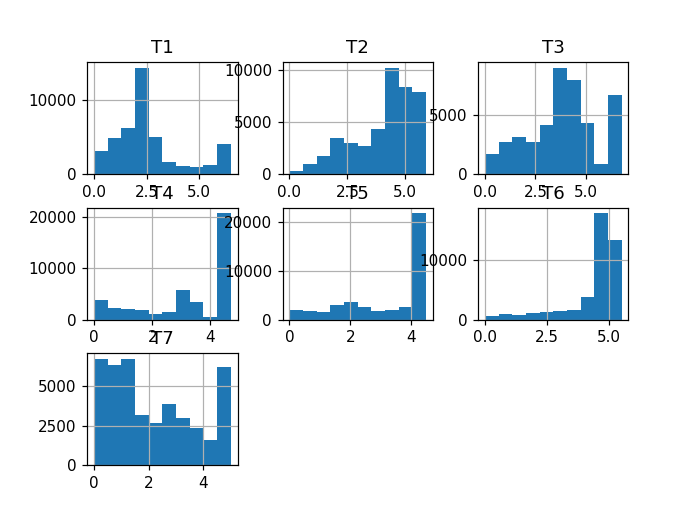

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f48b3c0d4d0>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f48b377e2d0>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f48b1862b90>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x7f48b2a45610>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f48b38fdbd0>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f48b343f150>],
       [<matplotlib.axes._subplots.AxesSubplot object at 0x7f48b3c01850>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f48b3c0b390>, <matplotlib.axes._subplots.AxesSubplot object at 0x7f48b3c0b990>]], dtype=object)

In [26]:
nn_input[('sys_states','tank_press')].hist()
#nn_input[('sys_inputs','head_pump_speed')].hist()
#nn_input[('sys_inputs','PRValve_dp')].hist()
#nn_input[('sys_inputs','TCValve_throttle')].hist()
#nn_input[('sys_inputs','jun_cl_demand_sum')].hist()


### Normalize Data:

In [27]:
input_offset = 0*nn_input.mean()
nn_input_offset = nn_input - input_offset

input_scaling = nn_input_offset.abs().max()
input_scaling.loc[input_scaling.abs()<1e-5]=1e-5
nn_input_scaled = nn_input_offset/input_scaling

output_offset = 0*nn_output.mean()
nn_output_offset = nn_output - output_offset

output_scaling = nn_output_offset.abs().max()
output_scaling.loc[output_scaling.abs()<1e-5]=1e-5
nn_output_scaled = nn_output_offset/output_scaling

### Train / Test Splitting

In [28]:
X_train, X_test, Y_train, Y_test = train_test_split(nn_input_scaled, nn_output_scaled, test_size=0.2)

In [29]:
X_train.shape

(34349, 46)

# Neural Network

## Create Model

In [30]:
n_layer = 5
n_units = 50
l1_regularizer = 0

model_param = {}
model_param['n_in'] = nn_input.shape[1]
model_param['n_out'] = nn_output.shape[1]
model_param['n_units'] = (n_layer)*[n_units]
model_param['activation'] = (n_layer) * ['tanh']

inputs = keras.Input(shape=(model_param['n_in'],))

layer_list = [inputs]


for i in range(len(model_param['n_units'])-1):
    layer_list.append(
        keras.layers.Dense(model_param['n_units'][i],
                           activation=model_param['activation'][i],
                           kernel_regularizer=keras.regularizers.l1(l=l1_regularizer)
                           )(layer_list[i])
    )

outputs = keras.layers.Dense(model_param['n_out'],
                             activation='linear')(layer_list[-1])

model = keras.Model(inputs=inputs, outputs=outputs)

model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 46)]              0         
_________________________________________________________________
dense (Dense)                (None, 50)                2350      
_________________________________________________________________
dense_1 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_2 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_3 (Dense)              (None, 50)                2550      
_________________________________________________________________
dense_4 (Dense)              (None, 42)                2142      
Total params: 12,142
Trainable params: 12,142
Non-trainable params: 0
_________________________________________________________

## Train model

In [31]:
optim = keras.optimizers.Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, amsgrad=False)
callback = keras.callbacks.EarlyStopping(monitor='loss', min_delta=1e-8, patience=50, mode='min')
model.compile(optimizer=optim,
              loss='mse')

In [32]:
history = model.fit(X_train.to_numpy(), 
                    Y_train.to_numpy(), 
                    batch_size=5000, 
                    epochs=3000,
                    validation_data=(X_test.to_numpy(),Y_test.to_numpy()),
                    callbacks=[callback])

Train on 34349 samples, validate on 8588 samples
Epoch 1/3000
34349/34349 [==============================] - 1s 41us/sample - loss: 0.1168 - val_loss: 0.0693
Epoch 2/3000
34349/34349 [==============================] - 0s 8us/sample - loss: 0.0568 - val_loss: 0.0411
Epoch 3/3000
34349/34349 [==============================] - 0s 9us/sample - loss: 0.0347 - val_loss: 0.0288
Epoch 4/3000
34349/34349 [==============================] - 0s 8us/sample - loss: 0.0280 - val_loss: 0.0266
Epoch 5/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0258 - val_loss: 0.0241
Epoch 6/3000
34349/34349 [==============================] - 0s 9us/sample - loss: 0.0233 - val_loss: 0.0219
Epoch 7/3000
34349/34349 [==============================] - 0s 9us/sample - loss: 0.0215 - val_loss: 0.0204
Epoch 8/3000
34349/34349 [==============================] - 0s 10us/sample - loss: 0.0202 - val_loss: 0.0193
Epoch 9/3000
34349/34349 [==============================] - 0s 8us/sample - loss: 0.0

34349/34349 [==============================] - 0s 9us/sample - loss: 0.0077 - val_loss: 0.0077
Epoch 76/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0077 - val_loss: 0.0077
Epoch 77/3000
34349/34349 [==============================] - 0s 8us/sample - loss: 0.0077 - val_loss: 0.0076
Epoch 78/3000
34349/34349 [==============================] - 0s 9us/sample - loss: 0.0076 - val_loss: 0.0076
Epoch 79/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0076 - val_loss: 0.0076
Epoch 80/3000
34349/34349 [==============================] - 0s 8us/sample - loss: 0.0076 - val_loss: 0.0076
Epoch 81/3000
34349/34349 [==============================] - 0s 8us/sample - loss: 0.0076 - val_loss: 0.0076
Epoch 82/3000
34349/34349 [==============================] - 0s 10us/sample - loss: 0.0076 - val_loss: 0.0076
Epoch 83/3000
34349/34349 [==============================] - 0s 8us/sample - loss: 0.0076 - val_loss: 0.0075
Epoch 84/3000
34349/34349 [=====

Epoch 150/3000
34349/34349 [==============================] - 0s 8us/sample - loss: 0.0065 - val_loss: 0.0066
Epoch 151/3000
34349/34349 [==============================] - 0s 9us/sample - loss: 0.0065 - val_loss: 0.0065
Epoch 152/3000
34349/34349 [==============================] - 0s 8us/sample - loss: 0.0065 - val_loss: 0.0065
Epoch 153/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0065 - val_loss: 0.0065
Epoch 154/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0065 - val_loss: 0.0065
Epoch 155/3000
34349/34349 [==============================] - 0s 8us/sample - loss: 0.0064 - val_loss: 0.0065
Epoch 156/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0064 - val_loss: 0.0064
Epoch 157/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0064 - val_loss: 0.0064
Epoch 158/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0064 - val_loss: 0.0064
Epoch 159/

34349/34349 [==============================] - 0s 8us/sample - loss: 0.0055 - val_loss: 0.0055
Epoch 225/3000
34349/34349 [==============================] - 0s 8us/sample - loss: 0.0055 - val_loss: 0.0055
Epoch 226/3000
34349/34349 [==============================] - 0s 9us/sample - loss: 0.0055 - val_loss: 0.0055
Epoch 227/3000
34349/34349 [==============================] - 0s 8us/sample - loss: 0.0055 - val_loss: 0.0054
Epoch 228/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0054 - val_loss: 0.0054
Epoch 229/3000
34349/34349 [==============================] - 0s 10us/sample - loss: 0.0054 - val_loss: 0.0054
Epoch 230/3000
34349/34349 [==============================] - 0s 9us/sample - loss: 0.0054 - val_loss: 0.0054
Epoch 231/3000
34349/34349 [==============================] - 0s 8us/sample - loss: 0.0054 - val_loss: 0.0054
Epoch 232/3000
34349/34349 [==============================] - 0s 8us/sample - loss: 0.0054 - val_loss: 0.0054
Epoch 233/3000
34349/343

34349/34349 [==============================] - 0s 8us/sample - loss: 0.0049 - val_loss: 0.0049
Epoch 299/3000
34349/34349 [==============================] - 0s 9us/sample - loss: 0.0049 - val_loss: 0.0049
Epoch 300/3000
34349/34349 [==============================] - 0s 9us/sample - loss: 0.0049 - val_loss: 0.0049
Epoch 301/3000
34349/34349 [==============================] - 0s 9us/sample - loss: 0.0050 - val_loss: 0.0049
Epoch 302/3000
34349/34349 [==============================] - 0s 8us/sample - loss: 0.0049 - val_loss: 0.0049
Epoch 303/3000
34349/34349 [==============================] - 0s 10us/sample - loss: 0.0049 - val_loss: 0.0049
Epoch 304/3000
34349/34349 [==============================] - 0s 8us/sample - loss: 0.0049 - val_loss: 0.0049
Epoch 305/3000
34349/34349 [==============================] - 0s 8us/sample - loss: 0.0049 - val_loss: 0.0049
Epoch 306/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0049 - val_loss: 0.0048
Epoch 307/3000
34349/343

34349/34349 [==============================] - 0s 8us/sample - loss: 0.0045 - val_loss: 0.0045
Epoch 373/3000
34349/34349 [==============================] - 0s 8us/sample - loss: 0.0045 - val_loss: 0.0045
Epoch 374/3000
34349/34349 [==============================] - 0s 8us/sample - loss: 0.0045 - val_loss: 0.0045
Epoch 375/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0045 - val_loss: 0.0045
Epoch 376/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0045 - val_loss: 0.0045
Epoch 377/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0045 - val_loss: 0.0045
Epoch 378/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0046 - val_loss: 0.0045
Epoch 379/3000
34349/34349 [==============================] - 0s 5us/sample - loss: 0.0045 - val_loss: 0.0045
Epoch 380/3000
34349/34349 [==============================] - 0s 5us/sample - loss: 0.0045 - val_loss: 0.0045
Epoch 381/3000
34349/3434

34349/34349 [==============================] - 0s 6us/sample - loss: 0.0042 - val_loss: 0.0042
Epoch 447/3000
34349/34349 [==============================] - 0s 5us/sample - loss: 0.0042 - val_loss: 0.0042
Epoch 448/3000
34349/34349 [==============================] - 0s 5us/sample - loss: 0.0042 - val_loss: 0.0042
Epoch 449/3000
34349/34349 [==============================] - 0s 5us/sample - loss: 0.0042 - val_loss: 0.0041
Epoch 450/3000
34349/34349 [==============================] - 0s 8us/sample - loss: 0.0042 - val_loss: 0.0042
Epoch 451/3000
34349/34349 [==============================] - 0s 5us/sample - loss: 0.0041 - val_loss: 0.0041
Epoch 452/3000
34349/34349 [==============================] - 0s 5us/sample - loss: 0.0041 - val_loss: 0.0041
Epoch 453/3000
34349/34349 [==============================] - 0s 5us/sample - loss: 0.0041 - val_loss: 0.0041
Epoch 454/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0042 - val_loss: 0.0041
Epoch 455/3000
34349/3434

34349/34349 [==============================] - 0s 12us/sample - loss: 0.0040 - val_loss: 0.0040
Epoch 521/3000
34349/34349 [==============================] - 0s 9us/sample - loss: 0.0040 - val_loss: 0.0039
Epoch 522/3000
34349/34349 [==============================] - 0s 9us/sample - loss: 0.0040 - val_loss: 0.0040
Epoch 523/3000
34349/34349 [==============================] - 0s 9us/sample - loss: 0.0040 - val_loss: 0.0039
Epoch 524/3000
34349/34349 [==============================] - 0s 10us/sample - loss: 0.0040 - val_loss: 0.0039
Epoch 525/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0039 - val_loss: 0.0039
Epoch 526/3000
34349/34349 [==============================] - 0s 8us/sample - loss: 0.0039 - val_loss: 0.0039
Epoch 527/3000
34349/34349 [==============================] - 0s 14us/sample - loss: 0.0039 - val_loss: 0.0039
Epoch 528/3000
34349/34349 [==============================] - 0s 13us/sample - loss: 0.0039 - val_loss: 0.0039
Epoch 529/3000
34349/

34349/34349 [==============================] - 0s 8us/sample - loss: 0.0038 - val_loss: 0.0038
Epoch 595/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0038 - val_loss: 0.0038
Epoch 596/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0038 - val_loss: 0.0038
Epoch 597/3000
34349/34349 [==============================] - 0s 5us/sample - loss: 0.0038 - val_loss: 0.0038
Epoch 598/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0038 - val_loss: 0.0038
Epoch 599/3000
34349/34349 [==============================] - 0s 8us/sample - loss: 0.0038 - val_loss: 0.0038
Epoch 600/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0038 - val_loss: 0.0038
Epoch 601/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0038 - val_loss: 0.0038
Epoch 602/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0038 - val_loss: 0.0038
Epoch 603/3000
34349/3434

34349/34349 [==============================] - 0s 7us/sample - loss: 0.0036 - val_loss: 0.0036
Epoch 669/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0036 - val_loss: 0.0036
Epoch 670/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0036 - val_loss: 0.0036
Epoch 671/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0036 - val_loss: 0.0036
Epoch 672/3000
34349/34349 [==============================] - 0s 5us/sample - loss: 0.0036 - val_loss: 0.0036
Epoch 673/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0036 - val_loss: 0.0037
Epoch 674/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0036 - val_loss: 0.0036
Epoch 675/3000
34349/34349 [==============================] - 0s 5us/sample - loss: 0.0036 - val_loss: 0.0037
Epoch 676/3000
34349/34349 [==============================] - 0s 5us/sample - loss: 0.0037 - val_loss: 0.0037
Epoch 677/3000
34349/3434

34349/34349 [==============================] - 0s 6us/sample - loss: 0.0036 - val_loss: 0.0035
Epoch 743/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0035 - val_loss: 0.0035
Epoch 744/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0035 - val_loss: 0.0036
Epoch 745/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0036 - val_loss: 0.0036
Epoch 746/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0035 - val_loss: 0.0036
Epoch 747/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0035 - val_loss: 0.0035
Epoch 748/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0035 - val_loss: 0.0036
Epoch 749/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0035 - val_loss: 0.0036
Epoch 750/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0035 - val_loss: 0.0035
Epoch 751/3000
34349/3434

34349/34349 [==============================] - 0s 8us/sample - loss: 0.0035 - val_loss: 0.0035
Epoch 817/3000
34349/34349 [==============================] - 0s 9us/sample - loss: 0.0035 - val_loss: 0.0035
Epoch 818/3000
34349/34349 [==============================] - 0s 8us/sample - loss: 0.0035 - val_loss: 0.0034
Epoch 819/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0034 - val_loss: 0.0035
Epoch 820/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0035 - val_loss: 0.0034
Epoch 821/3000
34349/34349 [==============================] - 0s 8us/sample - loss: 0.0034 - val_loss: 0.0035
Epoch 822/3000
34349/34349 [==============================] - 0s 8us/sample - loss: 0.0035 - val_loss: 0.0034
Epoch 823/3000
34349/34349 [==============================] - 0s 9us/sample - loss: 0.0034 - val_loss: 0.0035
Epoch 824/3000
34349/34349 [==============================] - 0s 8us/sample - loss: 0.0034 - val_loss: 0.0034
Epoch 825/3000
34349/3434

34349/34349 [==============================] - 0s 11us/sample - loss: 0.0034 - val_loss: 0.0033
Epoch 891/3000
34349/34349 [==============================] - 0s 12us/sample - loss: 0.0034 - val_loss: 0.0034
Epoch 892/3000
34349/34349 [==============================] - 0s 12us/sample - loss: 0.0034 - val_loss: 0.0034
Epoch 893/3000
34349/34349 [==============================] - 1s 15us/sample - loss: 0.0034 - val_loss: 0.0034
Epoch 894/3000
34349/34349 [==============================] - 0s 14us/sample - loss: 0.0034 - val_loss: 0.0033
Epoch 895/3000
34349/34349 [==============================] - 1s 15us/sample - loss: 0.0033 - val_loss: 0.0034
Epoch 896/3000
34349/34349 [==============================] - 0s 10us/sample - loss: 0.0034 - val_loss: 0.0034
Epoch 897/3000
34349/34349 [==============================] - 1s 15us/sample - loss: 0.0033 - val_loss: 0.0034
Epoch 898/3000
34349/34349 [==============================] - 0s 11us/sample - loss: 0.0034 - val_loss: 0.0033
Epoch 899/3000
3

34349/34349 [==============================] - 0s 7us/sample - loss: 0.0033 - val_loss: 0.0033
Epoch 965/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0033 - val_loss: 0.0033
Epoch 966/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0033 - val_loss: 0.0033
Epoch 967/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0033 - val_loss: 0.0033
Epoch 968/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0033 - val_loss: 0.0033
Epoch 969/3000
34349/34349 [==============================] - 0s 11us/sample - loss: 0.0033 - val_loss: 0.0033
Epoch 970/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0033 - val_loss: 0.0033
Epoch 971/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0033 - val_loss: 0.0033
Epoch 972/3000
34349/34349 [==============================] - 0s 9us/sample - loss: 0.0033 - val_loss: 0.0034
Epoch 973/3000
34349/343

34349/34349 [==============================] - 0s 6us/sample - loss: 0.0032 - val_loss: 0.0032
Epoch 1039/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0032 - val_loss: 0.0032
Epoch 1040/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0032 - val_loss: 0.0032
Epoch 1041/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0032 - val_loss: 0.0033
Epoch 1042/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0032 - val_loss: 0.0032
Epoch 1043/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0032 - val_loss: 0.0033
Epoch 1044/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0033 - val_loss: 0.0032
Epoch 1045/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0032 - val_loss: 0.0032
Epoch 1046/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0032 - val_loss: 0.0032
Epoch 1047/3000
3

Epoch 1112/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0031 - val_loss: 0.0032
Epoch 1113/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0032 - val_loss: 0.0032
Epoch 1114/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0032 - val_loss: 0.0031
Epoch 1115/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0031 - val_loss: 0.0031
Epoch 1116/3000
34349/34349 [==============================] - 0s 9us/sample - loss: 0.0031 - val_loss: 0.0031
Epoch 1117/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0031 - val_loss: 0.0031
Epoch 1118/3000
34349/34349 [==============================] - 0s 10us/sample - loss: 0.0031 - val_loss: 0.0031
Epoch 1119/3000
34349/34349 [==============================] - 0s 9us/sample - loss: 0.0031 - val_loss: 0.0031
Epoch 1120/3000
34349/34349 [==============================] - 0s 11us/sample - loss: 0.0031 - val_loss: 0.0031

34349/34349 [==============================] - 0s 10us/sample - loss: 0.0031 - val_loss: 0.0031
Epoch 1186/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0031 - val_loss: 0.0031
Epoch 1187/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0031 - val_loss: 0.0031
Epoch 1188/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0031 - val_loss: 0.0031
Epoch 1189/3000
34349/34349 [==============================] - 0s 10us/sample - loss: 0.0031 - val_loss: 0.0031
Epoch 1190/3000
34349/34349 [==============================] - 0s 9us/sample - loss: 0.0031 - val_loss: 0.0031
Epoch 1191/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0031 - val_loss: 0.0031
Epoch 1192/3000
34349/34349 [==============================] - 0s 9us/sample - loss: 0.0031 - val_loss: 0.0031
Epoch 1193/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0031 - val_loss: 0.0031
Epoch 1194/3000

Epoch 1259/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0030 - val_loss: 0.0030
Epoch 1260/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0030 - val_loss: 0.0030
Epoch 1261/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0030 - val_loss: 0.0030
Epoch 1262/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0030 - val_loss: 0.0030
Epoch 1263/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0030 - val_loss: 0.0030
Epoch 1264/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0030 - val_loss: 0.0031
Epoch 1265/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0030 - val_loss: 0.0030
Epoch 1266/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0030 - val_loss: 0.0030
Epoch 1267/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0030 - val_loss: 0.0031
E

Epoch 1333/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0030 - val_loss: 0.0030
Epoch 1334/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0030 - val_loss: 0.0030
Epoch 1335/3000
34349/34349 [==============================] - 0s 8us/sample - loss: 0.0030 - val_loss: 0.0030
Epoch 1336/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0030 - val_loss: 0.0030
Epoch 1337/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0030 - val_loss: 0.0030
Epoch 1338/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0030 - val_loss: 0.0030
Epoch 1339/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0030 - val_loss: 0.0030
Epoch 1340/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0030 - val_loss: 0.0030
Epoch 1341/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0030 - val_loss: 0.0030
E

Epoch 1407/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0029 - val_loss: 0.0029
Epoch 1408/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0029 - val_loss: 0.0029
Epoch 1409/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0029 - val_loss: 0.0029
Epoch 1410/3000
34349/34349 [==============================] - 0s 9us/sample - loss: 0.0029 - val_loss: 0.0029
Epoch 1411/3000
34349/34349 [==============================] - 0s 12us/sample - loss: 0.0029 - val_loss: 0.0029
Epoch 1412/3000
34349/34349 [==============================] - 0s 8us/sample - loss: 0.0029 - val_loss: 0.0029
Epoch 1413/3000
34349/34349 [==============================] - 0s 13us/sample - loss: 0.0029 - val_loss: 0.0030
Epoch 1414/3000
34349/34349 [==============================] - 0s 11us/sample - loss: 0.0029 - val_loss: 0.0029
Epoch 1415/3000
34349/34349 [==============================] - 0s 8us/sample - loss: 0.0029 - val_loss: 0.002

34349/34349 [==============================] - 0s 8us/sample - loss: 0.0029 - val_loss: 0.0029
Epoch 1481/3000
34349/34349 [==============================] - 0s 11us/sample - loss: 0.0029 - val_loss: 0.0029
Epoch 1482/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0029 - val_loss: 0.0029
Epoch 1483/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0029 - val_loss: 0.0029
Epoch 1484/3000
34349/34349 [==============================] - 0s 8us/sample - loss: 0.0029 - val_loss: 0.0029
Epoch 1485/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0029 - val_loss: 0.0029
Epoch 1486/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0029 - val_loss: 0.0029
Epoch 1487/3000
34349/34349 [==============================] - 0s 9us/sample - loss: 0.0028 - val_loss: 0.0029
Epoch 1488/3000
34349/34349 [==============================] - 0s 8us/sample - loss: 0.0029 - val_loss: 0.0029
Epoch 1489/3000


34349/34349 [==============================] - 0s 6us/sample - loss: 0.0029 - val_loss: 0.0029
Epoch 1554/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0029 - val_loss: 0.0029
Epoch 1555/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0029 - val_loss: 0.0029
Epoch 1556/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0029 - val_loss: 0.0029
Epoch 1557/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0029 - val_loss: 0.0029
Epoch 1558/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0029 - val_loss: 0.0028
Epoch 1559/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0028 - val_loss: 0.0029
Epoch 1560/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0028 - val_loss: 0.0028
Epoch 1561/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0028 - val_loss: 0.0028
Epoch 1562/3000
3

Epoch 1627/3000
34349/34349 [==============================] - 0s 5us/sample - loss: 0.0028 - val_loss: 0.0028
Epoch 1628/3000
34349/34349 [==============================] - 0s 5us/sample - loss: 0.0028 - val_loss: 0.0028
Epoch 1629/3000
34349/34349 [==============================] - 0s 5us/sample - loss: 0.0028 - val_loss: 0.0028
Epoch 1630/3000
34349/34349 [==============================] - 0s 5us/sample - loss: 0.0028 - val_loss: 0.0028
Epoch 1631/3000
34349/34349 [==============================] - 0s 5us/sample - loss: 0.0028 - val_loss: 0.0028
Epoch 1632/3000
34349/34349 [==============================] - 0s 5us/sample - loss: 0.0028 - val_loss: 0.0028
Epoch 1633/3000
34349/34349 [==============================] - 0s 5us/sample - loss: 0.0028 - val_loss: 0.0028
Epoch 1634/3000
34349/34349 [==============================] - 0s 5us/sample - loss: 0.0028 - val_loss: 0.0028
Epoch 1635/3000
34349/34349 [==============================] - 0s 5us/sample - loss: 0.0028 - val_loss: 0.0028
E

34349/34349 [==============================] - 0s 7us/sample - loss: 0.0027 - val_loss: 0.0028
Epoch 1701/3000
34349/34349 [==============================] - 0s 13us/sample - loss: 0.0027 - val_loss: 0.0028
Epoch 1702/3000
34349/34349 [==============================] - 0s 14us/sample - loss: 0.0027 - val_loss: 0.0028
Epoch 1703/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0027 - val_loss: 0.0027
Epoch 1704/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0027 - val_loss: 0.0028
Epoch 1705/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0028 - val_loss: 0.0028
Epoch 1706/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0027 - val_loss: 0.0028
Epoch 1707/3000
34349/34349 [==============================] - 0s 11us/sample - loss: 0.0027 - val_loss: 0.0028
Epoch 1708/3000
34349/34349 [==============================] - 0s 10us/sample - loss: 0.0027 - val_loss: 0.0028
Epoch 1709/30

Epoch 1774/3000
34349/34349 [==============================] - 0s 12us/sample - loss: 0.0027 - val_loss: 0.0027
Epoch 1775/3000
34349/34349 [==============================] - 0s 8us/sample - loss: 0.0027 - val_loss: 0.0027
Epoch 1776/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0027 - val_loss: 0.0027
Epoch 1777/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0027 - val_loss: 0.0027
Epoch 1778/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0027 - val_loss: 0.0027
Epoch 1779/3000
34349/34349 [==============================] - 0s 8us/sample - loss: 0.0027 - val_loss: 0.0027
Epoch 1780/3000
34349/34349 [==============================] - 0s 12us/sample - loss: 0.0027 - val_loss: 0.0027
Epoch 1781/3000
34349/34349 [==============================] - 0s 15us/sample - loss: 0.0027 - val_loss: 0.0027
Epoch 1782/3000
34349/34349 [==============================] - 0s 11us/sample - loss: 0.0027 - val_loss: 0.00

34349/34349 [==============================] - 0s 10us/sample - loss: 0.0027 - val_loss: 0.0027
Epoch 1848/3000
34349/34349 [==============================] - 0s 10us/sample - loss: 0.0027 - val_loss: 0.0027
Epoch 1849/3000
34349/34349 [==============================] - 0s 8us/sample - loss: 0.0027 - val_loss: 0.0027
Epoch 1850/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0027 - val_loss: 0.0027
Epoch 1851/3000
34349/34349 [==============================] - 0s 9us/sample - loss: 0.0027 - val_loss: 0.0027
Epoch 1852/3000
34349/34349 [==============================] - 0s 10us/sample - loss: 0.0027 - val_loss: 0.0027
Epoch 1853/3000
34349/34349 [==============================] - 0s 8us/sample - loss: 0.0027 - val_loss: 0.0027
Epoch 1854/3000
34349/34349 [==============================] - 0s 10us/sample - loss: 0.0027 - val_loss: 0.0027
Epoch 1855/3000
34349/34349 [==============================] - 0s 11us/sample - loss: 0.0027 - val_loss: 0.0027
Epoch 1856/3

Epoch 1921/3000
34349/34349 [==============================] - 0s 10us/sample - loss: 0.0027 - val_loss: 0.0027
Epoch 1922/3000
34349/34349 [==============================] - 0s 10us/sample - loss: 0.0027 - val_loss: 0.0027
Epoch 1923/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0027 - val_loss: 0.0027
Epoch 1924/3000
34349/34349 [==============================] - 0s 9us/sample - loss: 0.0027 - val_loss: 0.0027
Epoch 1925/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0027 - val_loss: 0.0027
Epoch 1926/3000
34349/34349 [==============================] - 0s 8us/sample - loss: 0.0026 - val_loss: 0.0027
Epoch 1927/3000
34349/34349 [==============================] - 0s 9us/sample - loss: 0.0026 - val_loss: 0.0027
Epoch 1928/3000
34349/34349 [==============================] - 0s 12us/sample - loss: 0.0027 - val_loss: 0.0027
Epoch 1929/3000
34349/34349 [==============================] - 0s 9us/sample - loss: 0.0026 - val_loss: 0.002

34349/34349 [==============================] - 0s 7us/sample - loss: 0.0026 - val_loss: 0.0026
Epoch 1995/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0026 - val_loss: 0.0027
Epoch 1996/3000
34349/34349 [==============================] - 0s 10us/sample - loss: 0.0026 - val_loss: 0.0027
Epoch 1997/3000
34349/34349 [==============================] - 0s 8us/sample - loss: 0.0026 - val_loss: 0.0027
Epoch 1998/3000
34349/34349 [==============================] - 0s 11us/sample - loss: 0.0026 - val_loss: 0.0027
Epoch 1999/3000
34349/34349 [==============================] - 0s 12us/sample - loss: 0.0026 - val_loss: 0.0027
Epoch 2000/3000
34349/34349 [==============================] - 0s 9us/sample - loss: 0.0026 - val_loss: 0.0026
Epoch 2001/3000
34349/34349 [==============================] - 0s 10us/sample - loss: 0.0026 - val_loss: 0.0026
Epoch 2002/3000
34349/34349 [==============================] - 0s 11us/sample - loss: 0.0026 - val_loss: 0.0026
Epoch 2003/3

Epoch 2068/3000
34349/34349 [==============================] - 0s 5us/sample - loss: 0.0026 - val_loss: 0.0026
Epoch 2069/3000
34349/34349 [==============================] - 0s 5us/sample - loss: 0.0026 - val_loss: 0.0026
Epoch 2070/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0026 - val_loss: 0.0026
Epoch 2071/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0026 - val_loss: 0.0026
Epoch 2072/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0026 - val_loss: 0.0026
Epoch 2073/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0026 - val_loss: 0.0026
Epoch 2074/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0026 - val_loss: 0.0026
Epoch 2075/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0026 - val_loss: 0.0026
Epoch 2076/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0026 - val_loss: 0.0026
E

Epoch 2142/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0026 - val_loss: 0.0026
Epoch 2143/3000
34349/34349 [==============================] - 0s 9us/sample - loss: 0.0026 - val_loss: 0.0027
Epoch 2144/3000
34349/34349 [==============================] - 0s 9us/sample - loss: 0.0026 - val_loss: 0.0026
Epoch 2145/3000
34349/34349 [==============================] - 0s 8us/sample - loss: 0.0026 - val_loss: 0.0027
Epoch 2146/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0026 - val_loss: 0.0026
Epoch 2147/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0026 - val_loss: 0.0026
Epoch 2148/3000
34349/34349 [==============================] - 0s 8us/sample - loss: 0.0026 - val_loss: 0.0026
Epoch 2149/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0025 - val_loss: 0.0026
Epoch 2150/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0025 - val_loss: 0.0026
E

34349/34349 [==============================] - 0s 10us/sample - loss: 0.0026 - val_loss: 0.0026
Epoch 2216/3000
34349/34349 [==============================] - 0s 10us/sample - loss: 0.0026 - val_loss: 0.0026
Epoch 2217/3000
34349/34349 [==============================] - 0s 8us/sample - loss: 0.0025 - val_loss: 0.0026
Epoch 2218/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0025 - val_loss: 0.0026
Epoch 2219/3000
34349/34349 [==============================] - 0s 5us/sample - loss: 0.0025 - val_loss: 0.0026
Epoch 2220/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0025 - val_loss: 0.0026
Epoch 2221/3000
34349/34349 [==============================] - 0s 7us/sample - loss: 0.0025 - val_loss: 0.0026
Epoch 2222/3000
34349/34349 [==============================] - 0s 6us/sample - loss: 0.0025 - val_loss: 0.0026
Epoch 2223/3000
34349/34349 [==============================] - 0s 5us/sample - loss: 0.0025 - val_loss: 0.0026
Epoch 2224/3000

Save model:

In [97]:
model_path = './models/'
model_name = '010_man_5x50_shift_x'
model.save(model_path+model_name+'.h5')

# train_data_param={
#     'input_offset': input_offset,
#     'input_scaling': input_scaling,
#     'output_offset': output_offset,
#     'output_scaling': output_scaling
# }

# with open(model_path+model_name+'_train_data_param.pkl','wb') as f:
#     pickle.dump(train_data_param, f)
    
with open(model_path+model_name+'_train_history.pkl','wb') as f:
    pickle.dump(history.history, f)

# Validation

In [33]:
data_path = '/home/ffiedler/tubCloud/Shared/WDN_SurrogateModels/_RESULTS/150sim_noControls/Validation/'
file_list = os.listdir(data_path)
file_list = [data_path+file_i for file_i in file_list if '.pkl' in file_i]

n_arx = 0
nn_input_val_list, nn_output_val_list = get_data(file_list, n_arx, cluster_labels, pressure_factor, narx_input=False, return_lists=True)

In [34]:
class simulator:
    def __init__(self, model, input_scaling, output_scaling, input_offset, output_offset, x0, t0):
        self.model = model
        
        self.input_scaling = input_scaling.to_numpy().reshape(1,-1)
        self.output_scaling = output_scaling.to_numpy().reshape(1,-1)
        self.input_offset = input_offset.to_numpy().reshape(1,-1)
        self.output_offset = output_offset.to_numpy().reshape(1,-1)
        
        self.x = x0
        self.n_x = x0.shape[1]
        self.aux = []
                
        self.t = np.array([t0]).reshape(-1,1)
        self.dt = 3600
            
    def eval_nn(self):
        # Scale input:
        self.nn_in = np.concatenate((self.x[[-1],:], self.u[[-1],:]),axis=1).reshape(1,-1)
        self.nn_in_scaled = (self.nn_in-self.input_offset)/self.input_scaling
        # Evaluate NN:
        self.nn_out_scaled = self.model.predict(self.nn_in_scaled)
        # Scale output:
        self.nn_out = self.nn_out_scaled*self.output_scaling+self.output_offset
#         x_new = self.nn_out[:,:self.n_x]
        x_new = self.x[[-1],:]+self.nn_out[:,:self.n_x]
        aux_new = self.nn_out[:,self.n_x:]
        self.aux.append(aux_new)
    
        self.x = np.append(self.x, x_new, axis=0)
        self.t = np.append(self.t, np.copy(self.t)[[-1]]+self.dt, axis=0)
        
        
    def next_step(self, sys_inputs_now):
        if 'u' in self.__dict__:
            self.u = np.append(self.u, sys_inputs_now.reshape(1,-1), axis=0)
        else:
            self.u = sys_inputs_now.reshape(1,-1)
        
        self.eval_nn()

In [35]:
val_i = 1

sys_states = nn_input_val_list[val_i]['sys_states']
sys_inputs = nn_input_val_list[val_i]['sys_inputs']
sys_aux_outputs = nn_output_val_list[val_i]['aux_outputs']

x0 = sys_states.head(1).to_numpy()
t0 = 0

nsim = simulator(model, input_scaling, output_scaling, input_offset, output_offset, x0, t0)

In [40]:
for k in range(100):
    print(k)
    sys_inputs_now = sys_inputs.iloc[k].to_numpy()
    nsim.next_step(sys_inputs_now)
sim_res = pd.DataFrame(nsim.x, columns=sys_states.columns, index=nsim.t.flatten())
sim_aux = pd.DataFrame(np.concatenate(nsim.aux), columns = sys_aux_outputs.columns,index=nsim.t.flatten()[:-1])

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


<IPython.core.display.Javascript object>


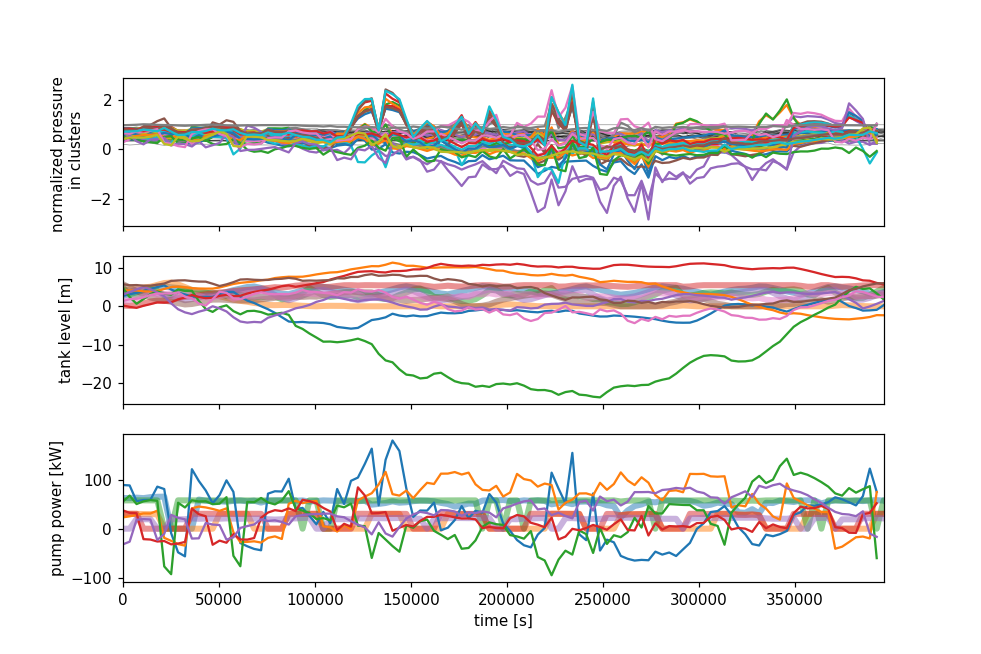

Text(0.5, 0, 'time [s]')

In [41]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(9,6))

sys_aux_outputs['jun_cl_press_mean'].plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
sim_aux['jun_cl_press_mean'].plot(ax=ax[0], legend=False)

sys_states['tank_press'].plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
sim_res['tank_press'].plot(ax=ax[1], legend=False)

sys_aux_outputs['pump_energy'].plot(ax=ax[2], legend=False, alpha=0.5, linewidth=4)
ax[2].set_prop_cycle(None)
sim_aux['pump_energy'].plot(ax=ax[2], legend=False)

ax[0].set_xlim(0, sim_res.index.max())
ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[2].set_ylabel('pump power [kW]')
ax[2].set_xlabel('time [s]')

# Linear Model

In [87]:
linear_reg = LinearRegression().fit(nn_input_scaled.to_numpy(), nn_output_scaled.to_numpy())

In [92]:
x0 = sys_states.head(1).to_numpy()
t0 = sys_states.head(1).index.to_numpy()

nsim_lin = simulator(linear_reg, input_scaling, output_scaling, input_offset, output_offset, x0, t0)

In [93]:
for k in range(10):
    print(k)
    sys_inputs_now = sys_inputs.iloc[k].to_numpy()
    nsim_lin.next_step(sys_inputs_now)
sim_res_lin = pd.DataFrame(nsim_lin.x, columns=sys_states.columns, index=nsim_lin.t.flatten())
sim_aux_lin = pd.DataFrame(np.concatenate(nsim_lin.aux), columns = sys_aux_outputs.columns,index=nsim_lin.t.flatten()[:-1])

0
1
2
3
4
5
6
7
8
9


<IPython.core.display.Javascript object>


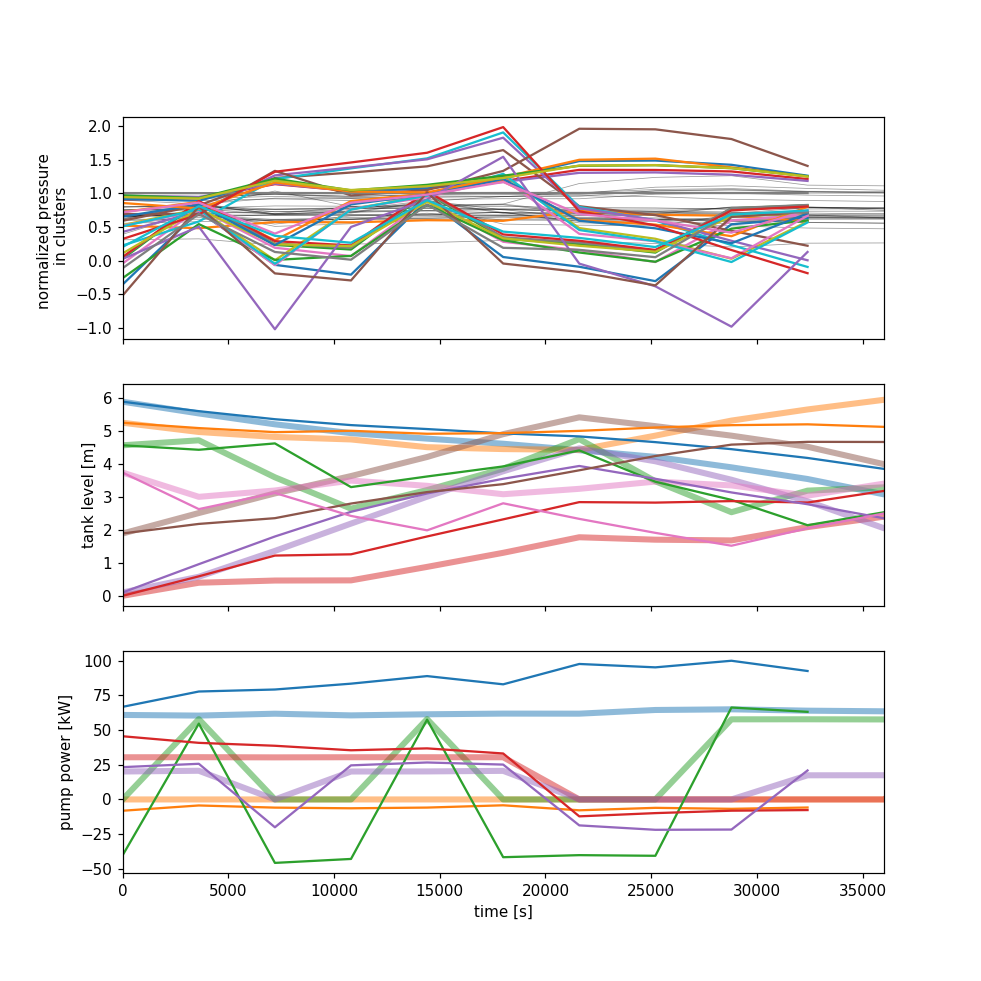

Text(0.5, 0, 'time [s]')

In [94]:
fig, ax = plt.subplots(3,1, sharex=True, figsize=(9,9))

sys_aux_outputs['jun_cl_press_mean'].plot(ax=ax[0], legend=False, linewidth=0.5, color='k', alpha=0.4)
sim_aux_lin['jun_cl_press_mean'].plot(ax=ax[0], legend=False)

sys_states['tank_press'].plot(ax=ax[1], legend=False, alpha=0.5, linewidth=4)
ax[1].set_prop_cycle(None)
sim_res_lin['tank_press'].plot(ax=ax[1], legend=False)

sys_aux_outputs['pump_energy'].plot(ax=ax[2], legend=False, alpha=0.5, linewidth=4)
ax[2].set_prop_cycle(None)
sim_aux_lin['pump_energy'].plot(ax=ax[2], legend=False)

ax[0].set_xlim(0, sim_res_lin.index.max())
ax[0].set_ylabel('normalized pressure \n in clusters')
ax[1].set_ylabel('tank level [m]')
ax[2].set_ylabel('pump power [kW]')
ax[2].set_xlabel('time [s]')